# SEP532 인공지능 이론과 실제
## Deep Learning Practice 
#### Prof. Ho-Jin Choi
#### School of Computing, KAIST

---

### 3-3. Image classification using CNN

In this notebook, we will implement a convolutional neural network (CNN) to classify cats or dogs from image. It builds an image classifier using a `tf.keras.Sequential` model and load data using [`tf.keras.preprocessing.image.ImageDataGenerator`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator). ImageDataGenerator class will be used for building _data input pipelines_ to efficiently work with data on disk to use with the model. Besides, this will be used for _data augmentation_ as a technique to fight overfitting in computer vision tasks. 

First, Import required packages

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt

#### Load data

Begin by downloading the dataset. This practice uses a filtered version of [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats/data) dataset from Kaggle.

+구글 드라이브 연동하는거 추가

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# Basically, data will be stored in ~/.keras/dataset/
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

The dataset has the following directory structure:

cats_and_dogs_filtered <br>
|__ train <br>
&emsp;|____________ cats: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....] <br>
&emsp;|____________ dogs: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...] <br>
|__ validation <br>
&emsp;|____________ cats: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....] <br>
&emsp;|____________ dogs: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...] <br>

After extracting its contents, assign variables with the proper file path for the training and validation set.

In [3]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [4]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

#### Understand the data

Let's look at how many cats and dogs images are in the training and validation directory:

In [5]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [6]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


For convenience, set up variables to use while pre-processing the dataset and training the network.

In [7]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

#### Data preparation
Format the images into appropriately **pre-processed floating point tensors** before feeding to the network:

1. Read images from the disk.
1. Decode contents of these images and convert it into proper grid format as per their RGB content.
1. Convert them into floating point tensors.
1. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done with the `ImageDataGenerator` class provided by `tf.keras`. It can read images from disk and **preprocess them into proper tensors**. It will also set up generators that **convert these images into batches** of tensors—helpful when training the network.

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the generators for training and validation images with rescalling factor
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

By using the `frow_from_directory` function, load images from the disk, applies rescaling, and resizes the images into the required dimensions.


In [9]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [10]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


In [11]:
!pip install pillow

#### Visualize training images
Visualize the training images by extracting a batch of images from the training generator—which is 32 images in this example—then plot five of them with matplotlib.

In [12]:
sample_training_images, _ = next(train_data_gen)

The `next` function returns a batch from the dataset. The return value of next function is in form of (x_train, y_train) where x_train is training features and y_train, its labels. Discard the labels to only visualize the training images.

In [13]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

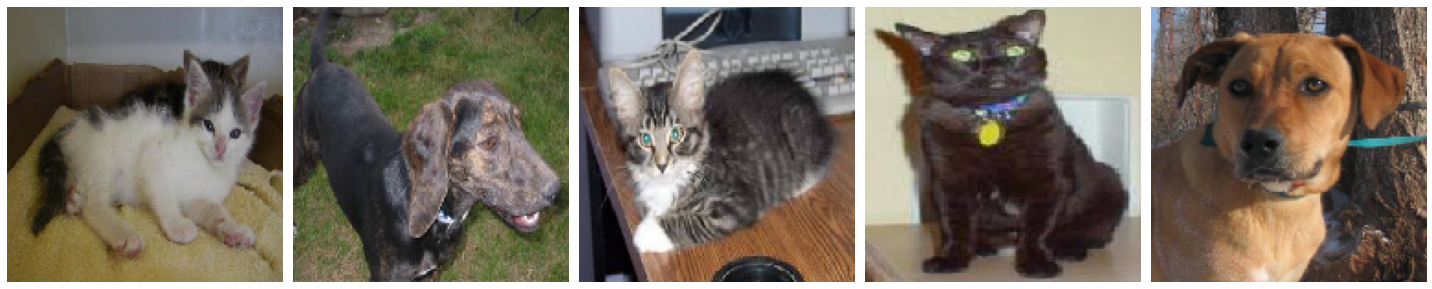

In [14]:
plotImages(sample_training_images[:5])

#### Create model 

The model consists of **three convolution blocks with a max pool layer** in each of them. There's a **fully connected layer with 512 units** on top of it that is activated by a _relu activation function_. The model outputs class probabilities based on **binary classification** by the _sigmoid activation function_.

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

#### Compile the model
For this tutorial, choose the _ADAM optimizer_ and _binary cross entropy loss function_.

In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#### Train the model 

Use the `fit_generator` method of the `ImageDataGenerator` class to train the network.

_steps_per_epoch_: Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch.   
_validation_steps_:  Total number of steps (batches of samples) to draw before stopping when performing validation at the end of every epoch.

In [17]:
history = model.fit_generator(train_data_gen,
                              steps_per_epoch=total_train // batch_size,
                              epochs=epochs,
                              validation_data=val_data_gen,
                              validation_steps=total_val // batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 15 steps, validate for 7 steps
Epoch 1/15
15/15 [==============================] - 15s 992ms/step - loss: 0.9939 - accuracy: 0.5016 - val_loss: 0.6921 - val_accuracy: 0.5112
Epoch 2/15
15/15 [==============================] - 14s 952ms/step - loss: 0.6900 - accuracy: 0.5465 - val_loss: 0.6833 - val_accuracy: 0.5134
Epoch 3/15
15/15 [==============================] - 14s 947ms/step - loss: 0.6775 - accuracy: 0.5438 - val_loss: 0.6701 - val_accuracy: 0.5737
Epoch 4/15
15/15 [==============================] - 14s 956ms/step - loss: 0.6458 - accuracy: 0.6608 - val_loss: 0.6311 - val_accuracy: 0.6551
Epoch 5/15
15/15 [==============================] - 14s 956ms/step - loss: 0.6008 - accuracy: 0.6816 - val_loss: 0.5993 - val_accuracy: 0.6797
Epoch 6/15
15/15 [==============================] - 14s 951ms/step - loss: 0.5706 - accuracy: 0.6976 - val_loss: 0.620

#### Visualize training results
Now visualize the results after training the network.

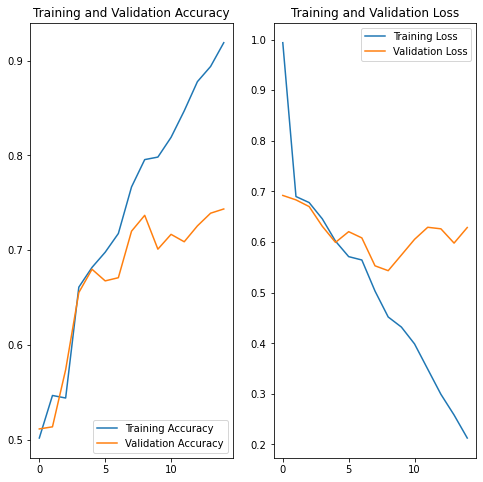

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As you can see from the plots, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 70% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable. Thus, we can think that this is the overfitting problem as we checked in previous class. 

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as _overfitting_. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this practice, you'll use _data augmentation_ and add _dropout_ to our model.

#### Data augmentation
Overfitting generally occurs when there are a small number of training examples. One way to fix this problem is to **augment the dataset so that it has a sufficient number of training examples**. Data augmentation takes the approach of generating more training data from existing training samples by augmenting the samples using random transformations that yield believable-looking images. The goal is the model will never see the exact same picture twice during training. This helps expose the model to more aspects of the data and generalize better.

Implement this in `tf.keras` using the [`ImageDataGenerator`](https://keras.io/preprocessing/image/) class. Pass different transformations to the dataset and it will take care of applying it during the training process.


**Arguments list of `ImageDataGenerator`** 
- featurewise_center
- samplewise_center
- featurewise_std_normalization
- samplewise_std_normalization
- zca_epsilon
- zca_whitening
- rotation_range
- width_shift_range
- height_shift_range
- brightness_range
- shear_range
- zoom_range
-  fill_mode
- cval
- horizontal_flip
- vertical_flip
- preprocessing_function
- data_format
- validation_split
- dtype

**Apply horizontal flip**

Pass `horizontal_flip` as an argument to the `ImageDataGenerator` class and set it to True to apply this augmentation.

In [19]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [20]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 2000 images belonging to 2 classes.


Take one sample image from the training examples and repeat it five times so that the augmentation is applied to the same image five times.

In [21]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

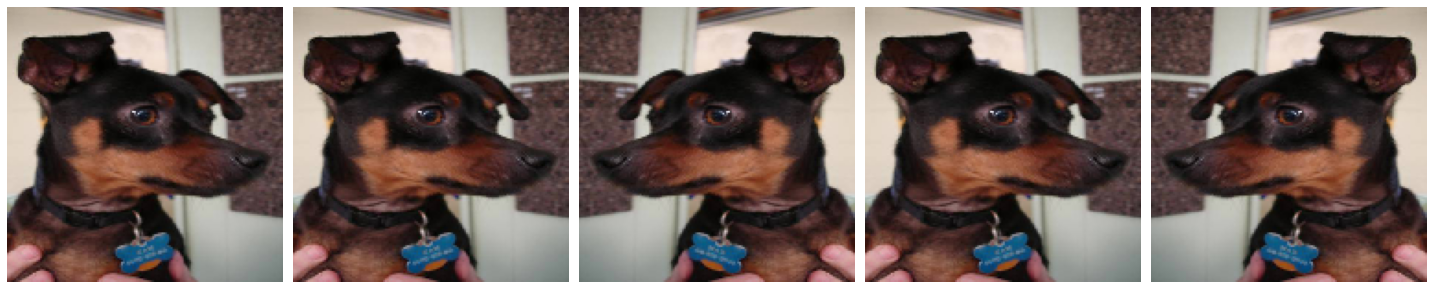

In [22]:
# Re-use the same custom plotting function defined and used
# above to visualize the training images
plotImages(augmented_images)

**Randomly rotate the image**

Let's take a look at a different augmentation called rotation and apply 45 degrees of rotation randomly to the training examples.

In [23]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [24]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


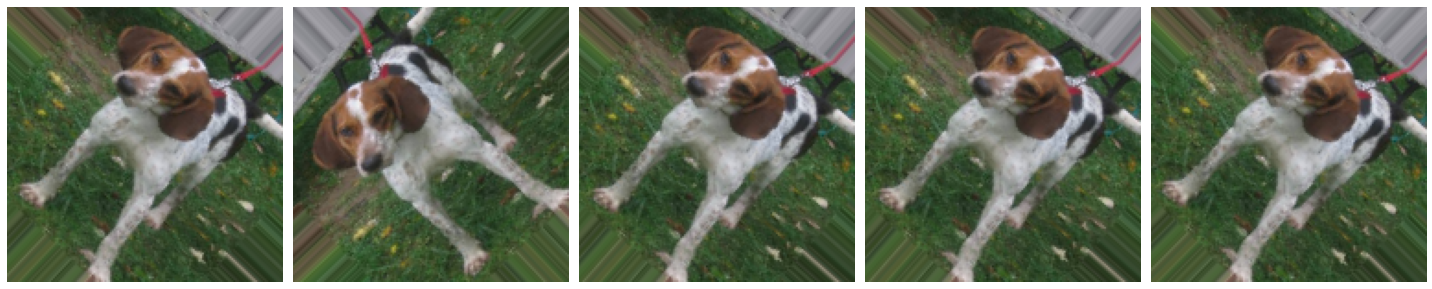

In [25]:
plotImages(augmented_images)

**Apply zoom augmentation**

Apply a zoom augmentation to the dataset to zoom images up to 50% randomly.

In [26]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

In [27]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


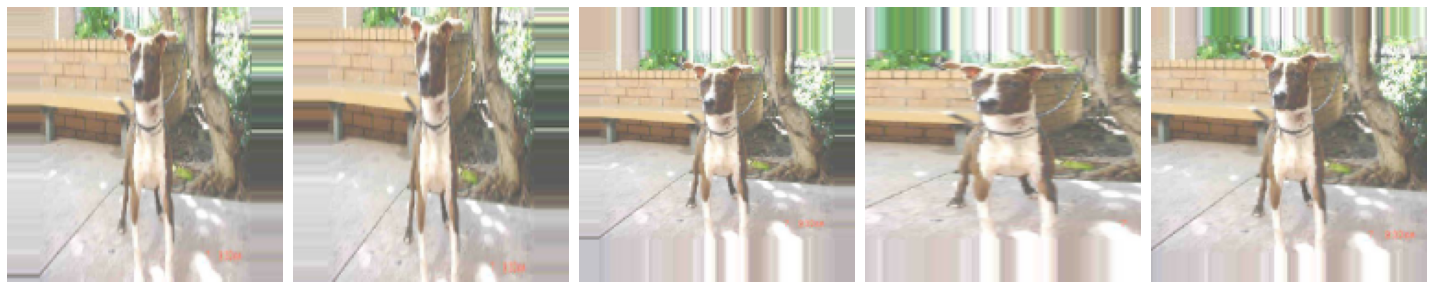

In [28]:
plotImages(augmented_images)

#### Put it all together
Apply all the previous augmentations. Here, you applied rescale, 45 degree rotation, width shift, height shift, horizontal flip and zoom augmentation to the training images.

In [29]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5)

In [31]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


Visualize how a single image would look five different times when passing these augmentations randomly to the dataset.

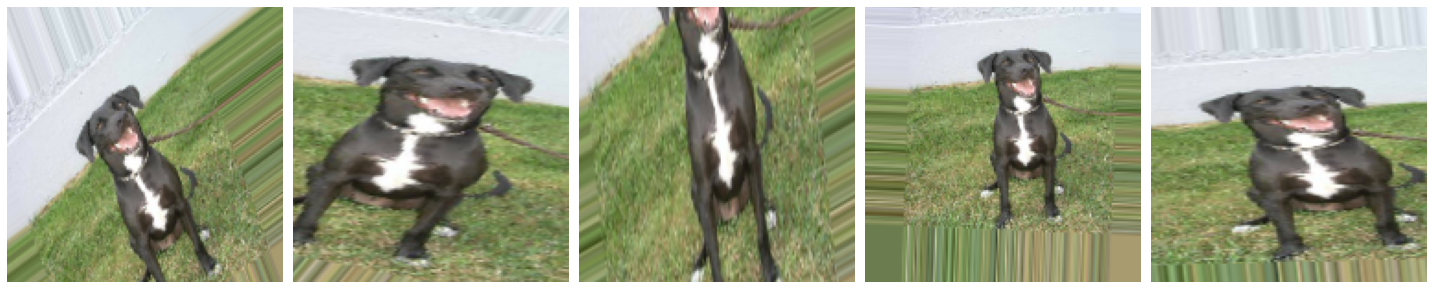

In [32]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

#### Create validation data generator
Generally, only apply data augmentation to the training examples. In this case, only rescale the validation images and convert them into batches using `ImageDataGenerator`.

In [33]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [34]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')


Found 1000 images belonging to 2 classes.


#### Creating a new network with Dropouts

Here, you apply dropout to first and last max pool layers and to a fully connected layer that has 512 output units. 30% of the first and last max pool layer, and 10% of fully connected layer output units, are randomly set to zero during each training epoch.

In [35]:
from tensorflow.keras.layers import Dropout

model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    
    Dropout(0.2),
    
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    
    Dropout(0.2),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

#### Compile the model
After introducing dropouts to the network, compile the model and view the layers summary.

In [36]:
model_new.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 64)       

#### Train the model
After successfully introducing data augmentations to the training examples and adding dropouts to the network, train this new network:

In [37]:
history = model_new.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 15 steps, validate for 7 steps
Epoch 1/15
15/15 [==============================] - 19s 1s/step - loss: 1.6885 - accuracy: 0.4984 - val_loss: 0.6923 - val_accuracy: 0.5033
Epoch 2/15
15/15 [==============================] - 18s 1s/step - loss: 0.6925 - accuracy: 0.5150 - val_loss: 0.6868 - val_accuracy: 0.5435
Epoch 3/15
15/15 [==============================] - 19s 1s/step - loss: 0.6878 - accuracy: 0.5240 - val_loss: 0.6792 - val_accuracy: 0.5625
Epoch 4/15
15/15 [==============================] - 18s 1s/step - loss: 0.6812 - accuracy: 0.5529 - val_loss: 0.6714 - val_accuracy: 0.5926
Epoch 5/15
15/15 [==============================] - 19s 1s/step - loss: 0.6747 - accuracy: 0.5812 - val_loss: 0.6584 - val_accuracy: 0.6049
Epoch 6/15
15/15 [==============================] - 19s 1s/step - loss: 0.6774 - accuracy: 0.5721 - val_loss: 0.6670 - val_accuracy: 0.5993
Epoch 7/15
15/15 [==============================] - 19s 1s/step - los

#### Visualize the model
Visualize the new model after training, you can see that there is significantly less overfitting than before. The accuracy should go up after training the model for more epochs.

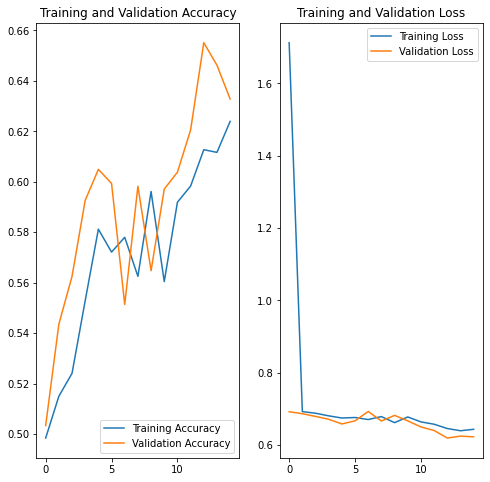

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()